In [109]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import sys
sys.path.append('./python_files/')
from model_trainer import ModelTrainer
from utils import *
from data_loader import load_data
from nn_modules import View
from nn_models import LeNet, aliG

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print("pytorch version: ",torch.__version__)

'0.4.1'

In [ ]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

## Loading the data (MNIST)

In [30]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False, full=True)

train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
** Use 60000 train and 10000 test samples


In [31]:
print("# of training samples : "+str(len(train_input)))

# of training samples : 60000


## 1) LeNet with disjoint trainset and testset

In [40]:
train_dataset = (train_input[0:3000], train_target[0:3000])
test_dataset = (test_input, test_target)

In [33]:
crossEntropyClassesWeigths = computeClassesWeights(train_target)

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                       0.00448           0.236         0.00021           0.484
10                      0.00056           0.920         0.00003           0.910
20                      0.00025           0.966         0.00002           0.947
30                      0.00015           0.982         0.00001           0.960
40                      0.00010           0.991         0.00001           0.965
49                      0.00018           0.978         0.00001           0.956
*******************************************************************************


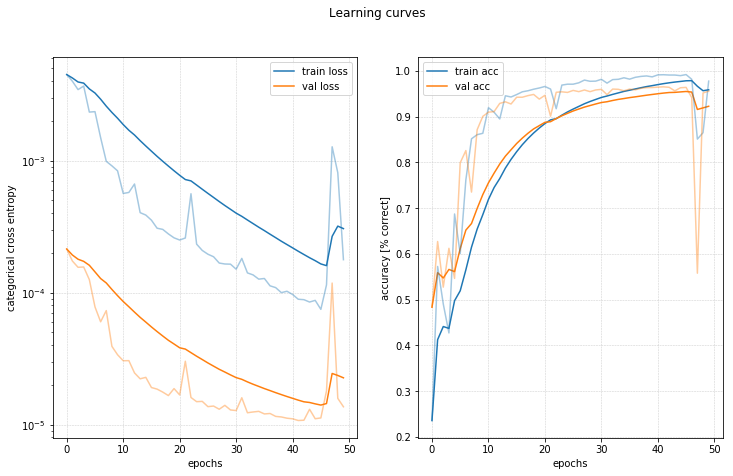

In [34]:
model = LeNet()

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.1

mt = ModelTrainer(model, loss_fun, optim.SGD(model.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, test_dataset, epochs=50, batch_size=500, verbose=10)
mt.plot_training("Learning curves")

## 2) Extract layers activations examples

In [35]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [12]:
#Can use the handle to remove the hook, don't execute twice on 
#the same handle, or you won't be able to remove the first
#instance of the hook
output_d, handles_d  = spyOn([model.conv2, model.fc1], ['convolution 2', 'FC_1'], True)

In [13]:
model(train_input[0:10].reshape(-1, 1, 28, 28))

captured output at layer : Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
captured output at layer : Linear(in_features=256, out_features=200, bias=True)


tensor([[  0.7586,  -1.8530,  -2.1456,  10.7991, -10.6192,  16.4166,  -5.0290,
          -3.7234,   2.9299,  -1.9552],
        [ 17.1613,  -8.1253,   2.0284,  -6.1224,  -6.5811,   3.1431,   1.1570,
          -0.0177,  -5.1776,   5.3938],
        [-10.6030,   1.7313,  -0.7599,  -1.4215,  16.3932,  -4.0320,  -3.3717,
           0.9547,  -5.9806,   4.0728],
        [ -6.9471,  16.5952,   5.0940,  -5.3112,  -0.1019, -13.1760,  -2.0443,
           4.2381,   2.9331,  -6.2808],
        [-10.0647,  -1.6857,  -8.6207,  -1.2463,   7.0248,  -2.6333, -11.0354,
           2.9723,   4.2054,  16.7280],
        [  0.9311,  -6.2702,  11.3685,   3.2029, -10.4618,   1.9653,  -3.8472,
          -0.8466,   4.7750,  -0.9605],
        [-10.1329,  11.1448,   0.8984,  -1.4977,   0.2705,  -1.3259,   0.2964,
          -1.5366,   3.4112,  -3.8724],
        [ -2.3174,  -5.4460,   3.1972,  22.1556, -14.4381,   2.9266, -16.5932,
          -2.7892,   6.9326,   3.7202],
        [ -8.2024,  11.4234,  -1.0011,  -3.5596,

In [18]:
output_d['convolution 2'].reshape(10, -1).shape

torch.Size([10, 1024])

## 3) Differentiate layer activation from training sample than one from a testing sample

In [120]:
modelG = aliG(140)

In [124]:
data = torch.Tensor(10, 1, 140)

In [125]:
data.shape

torch.Size([10, 1, 140])

In [126]:
debug_layers_dims(modelG, data.shape)

******************** Debugging layers sizes: ********************
input_shape= (_,1,140)
------------------
Conv1d(1, 32, kernel_size=(8,), stride=(1,))
(_,1,140) --> (_,32,133)
------------------
MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(_,32,133) --> (_,32,66)
------------------
Conv1d(32, 128, kernel_size=(5,), stride=(1,))
(_,32,66) --> (_,128,62)
------------------
MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(_,128,62) --> (_,128,31)
------------------
Conv1d(128, 16, kernel_size=(3,), stride=(1,))
(_,128,31) --> (_,16,29)
------------------
MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(_,16,29) --> (_,16,14)
------------------
View(_, [-1])
(_,16,14) --> (_,224)
------------------
Linear(in_features=224, out_features=100, bias=True)
(_,224) --> (_,100)
------------------
Linear(in_features=100, out_features=32, bias=True)
(_,100) --> (_,32)
------------------
Linear(in_features=32, out_

tensor([[-0.0601],
        [-0.0713]], grad_fn=<ThAddmmBackward>)